In [2]:
from __future__ import division
import pandas as pd
import numpy as np

# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.sql.functions import mean as sql_mean

# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import colorsys
import random

import matplotlib.pyplot as plt
% matplotlib inline

## Now that our database is saved as a parquet, we can query it directly

In [5]:
# Use formatting to set table name

table = "parquet.`data/excerpt_df.parquet`"

spark.sql('''
    SELECT author, tokenized, w2v 
    FROM {}
    LIMIT 10
    '''.format(table)).show()

+--------------+--------------------+--------------------+
|        author|           tokenized|                 w2v|
+--------------+--------------------+--------------------+
|CharlesDickens|[a, christmas, ca...|[-0.1702252033501...|
|CharlesDickens|[mind, i, dont, m...|[-0.2174013902028...|
|CharlesDickens|[scrooge, never, ...|[-0.1526826002821...|
|CharlesDickens|[nobody, ever, st...|[-0.1897002885570...|
|CharlesDickens|[the, door, of, s...|[-0.1829826451034...|
|CharlesDickens|[i, do, said, scr...|[-0.2629524400289...|
|CharlesDickens|[uncle, pleaded, ...|[-0.2502119612455...|
|CharlesDickens|[the, clerk, in, ...|[-0.2832240152638...|
|CharlesDickens|[i, am, sorry, wi...|[-0.1989532466069...|
|CharlesDickens|[mr, marley, has,...|[-0.2183633688141...|
+--------------+--------------------+--------------------+



## Make Plotting Functions

In [14]:
# thankyou nick for the plotting code
# rework further in my own sparky style 

def make_plots(DFs, col, bins, title, colors, x_lab, authors, x_lim=None, y_lim=None):
    plt.subplots(4,4,sharex=True, sharey=True, figsize=(10,10))
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.suptitle(title, fontsize=18)
    for i, DF in enumerate(DFs):
        make_hist(DF, col, bins, colors[i], x_lim, y_lim, i, x_lab, authors[i])
    
    
def make_hist(DF, col, bins, color, x_lim, y_lim, i, x_lab, author):
    # Create pandas DF of bins and counts
    temp_df = DF.select(col).toPandas()
    plt.subplot(2,2,i+1)
    plt.hist(temp_df[col], bins, normed=1, color=color, 
             alpha=0.4, label=author)
    # Find mean sentence length
    x_val = DF.select(sql_mean(col)).select('avg('+col+')').head()[0]
    plt.axvline(x=x_val, color=color, label="Mean", linewidth=1.5)
    plt.xlabel(x_lab)
    plt.ylabel("Frequency")
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.legend();

In [4]:
def metadata_df(author):
    author = "'" + author + "'"
    return spark.sql('''
        SELECT char_count, avg_wordlen, word_count, sent_length 
        FROM {} 
        WHERE author = {} AND sent_length <=100
        '''.format(table, author))



twaindf = metadata_df('MarkTwain')
muirdf = metadata_df('JohnMuir')
austendf = metadata_df('JaneAusten')
dickensdf = metadata_df('CharlesDickens')


In [ ]:
twaindf.show(5)

## Plot Metadata

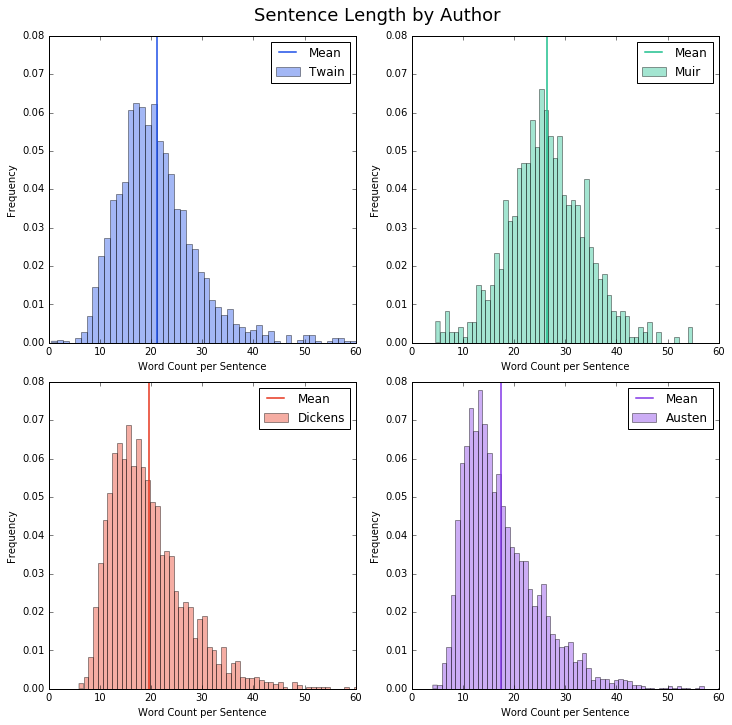

In [15]:
DFs = [twaindf, muirdf, austendf, dickensdf]
authors = ["Twain", "Muir", "Dickens", "Austen"]
colors = [[0.1, 0.3, .9], [0.1, 0.75, 0.55], [0.9, 0.2, 0.1], [0.5, 0.2, 0.9]]

# Make Sentence Length Histograms
make_plots(DFs=DFs, col='sent_length', bins=75, title='Sentence Length by Author',
           colors=colors, x_lim=(0,60), y_lim=(0, 0.08), x_lab="Word Count per Sentence", authors=authors)
plt.savefig('data/images/sent_len.png', bbox_inches='tight')

## Build Word Clouds:

In [3]:
def get_all_text(author, table="parquet.`data/excerpt_df.parquet`"):
    author = "'" + author + "'"  
    excerpts = spark.sql('''
        SELECT excerpt
        FROM {}
        WHERE author = {}
        '''.format(table, author))
    

    return ' '.join([str(e) for e in excerpts.collect()])





In [30]:
excerpts = spark.sql('''
    SELECT words_only
    FROM {}
    WHERE author = {}
    '''.format(table, "'MarkTwain'"))

type(excerpts)

# alltext = ' '.join([str(e) for e in excerpts.excerpt])

pyspark.sql.dataframe.DataFrame

In [8]:
spark.sql('''
    SELECT words_only
    FROM {}
    WHERE author = {}
    LIMIT 10
    '''.format(table, "'MarkTwain'")).show()

+--------------------+
|          words_only|
+--------------------+
|A CONNECTICUT YAN...|
|“You know about t...|
|HOW SIR LAUNCELOT...|
|And then they all...|
|As I laid the boo...|
|Well a man like t...|
|“Fair sir will ye...|
|“Bridgeport” said...|
|  THE TALE OF THE...|
|As we approached ...|
+--------------------+



In [37]:
print excerpts.collect()[6][0]
print
print excerpts.collect()[6]

“Fair sir will ye just” said this fellow  “Will I which”  “Will ye try a passage of arms for land or lady or for”  “What are you giving me” I said “Get along back to your circus or I’ll report you”  Now what does this man do but fall back a couple of hundred yards and then come rushing at me as hard as he could tear with his nailkeg bent down nearly to his horse’s neck and his long spear pointed straight ahead I saw he meant business so I was up the tree when he arrived  He allowed that I was his property the captive of his spear There was argument on his sideand the bulk of the advantage so I judged it best to humor him We fixed up an agreement whereby I was to go with him and he was not to hurt me I came down and we started away I walking by the side of his horse We marched comfortably along through glades and over brooks which I could not remember to have seen beforewhich puzzled me and made me wonderand yet we did not come to any circus or sign of a circus So I gave up the idea of 

In [33]:
ord("“")

TypeError: ord() expected a character, but string of length 3 found

In [34]:
chr('\u201d')

TypeError: an integer is required